# Customer Churn Analysis

This notebook analyzes a synthetic subscription dataset to predict **customer churn** and surface actionable drivers of churn.

**Steps:**
1. Load data
2. Quick EDA
3. Preprocessing & train/validation split
4. Baseline models (Logistic Regression, Random Forest)
5. Evaluation (classification report, ROC-AUC)
6. Interpretability (coefficients & feature importances)


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Load data
df = pd.read_csv("/mnt/data/customer_churn/data/churn_data.csv")
df.head()


,customer_id,age,senior_citizen,tenure_months,contract,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,1,23,0,16,Month-to-month,Bank transfer,Fiber optic,1,1,0,1,0,1,0,77.30,1252.57,1
1,2,65,1,18,Two year,Debit card,Fiber optic,1,1,0,0,1,1,1,91.49,1680.17,0
2,3,58,0,7,Month-to-month,Credit card,DSL,0,1,0,0,1,0,0,71.91,531.65,1
3,4,45,0,9,Month-to-month,Credit card,DSL,1,1,1,0,1,1,1,82.45,819.42,0
4,5,44,0,23,One year,Credit card,DSL,1,0,1,0,1,1,1,80.27,1895.88,0


Shape: (8000, 17)

Churn rate: 0.525

Contract distribution:
Month-to-month    0.573
One year          0.262
Two year          0.166
Name: contract, dtype: float64

Payment method distribution:
Electronic check    0.278
Credit card         0.276
Bank transfer       0.227
Debit card          0.219
Name: payment_method, dtype: float64

Internet service distribution:
Fiber optic    0.523
DSL            0.348
None           0.128
Name: internet_service, dtype: float64


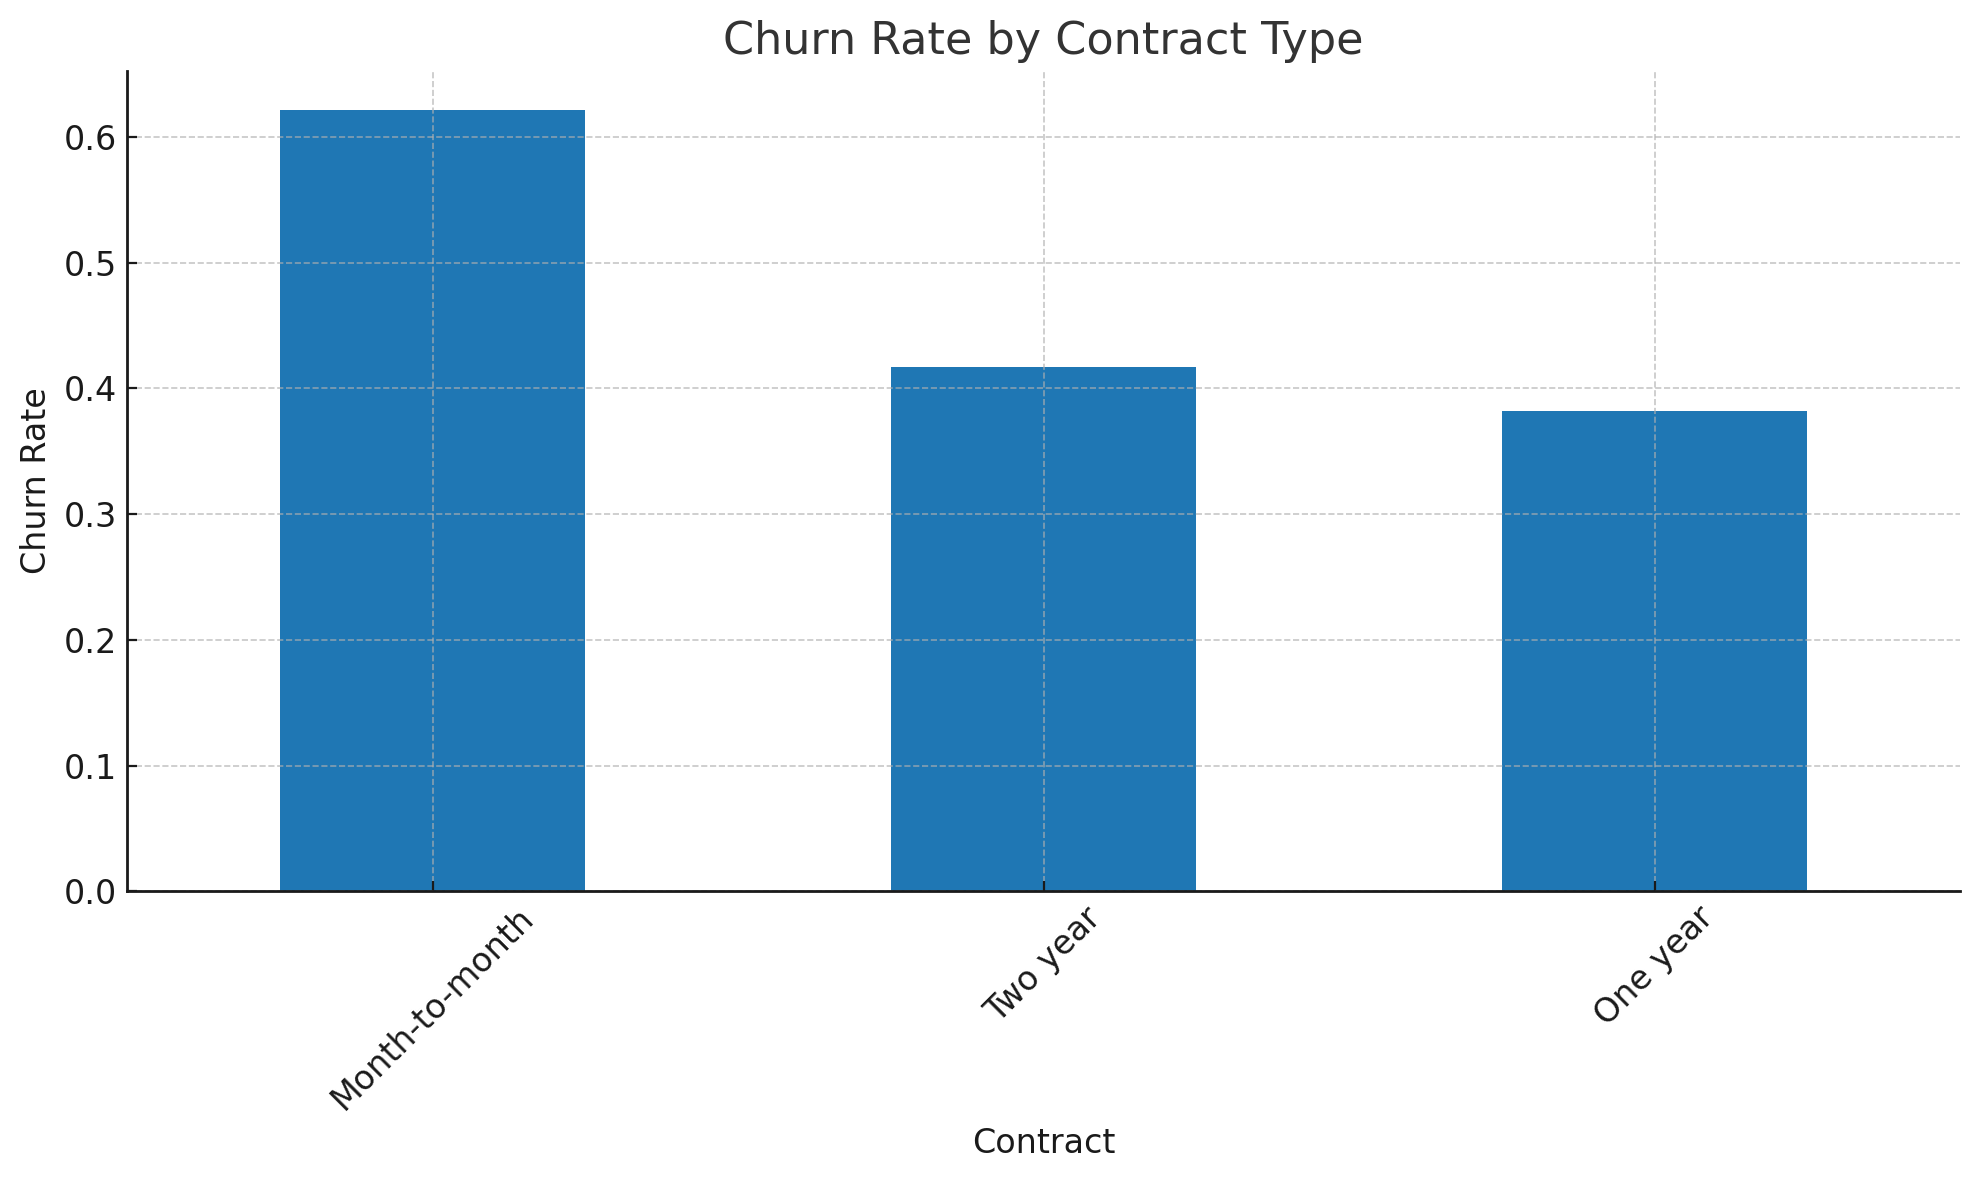

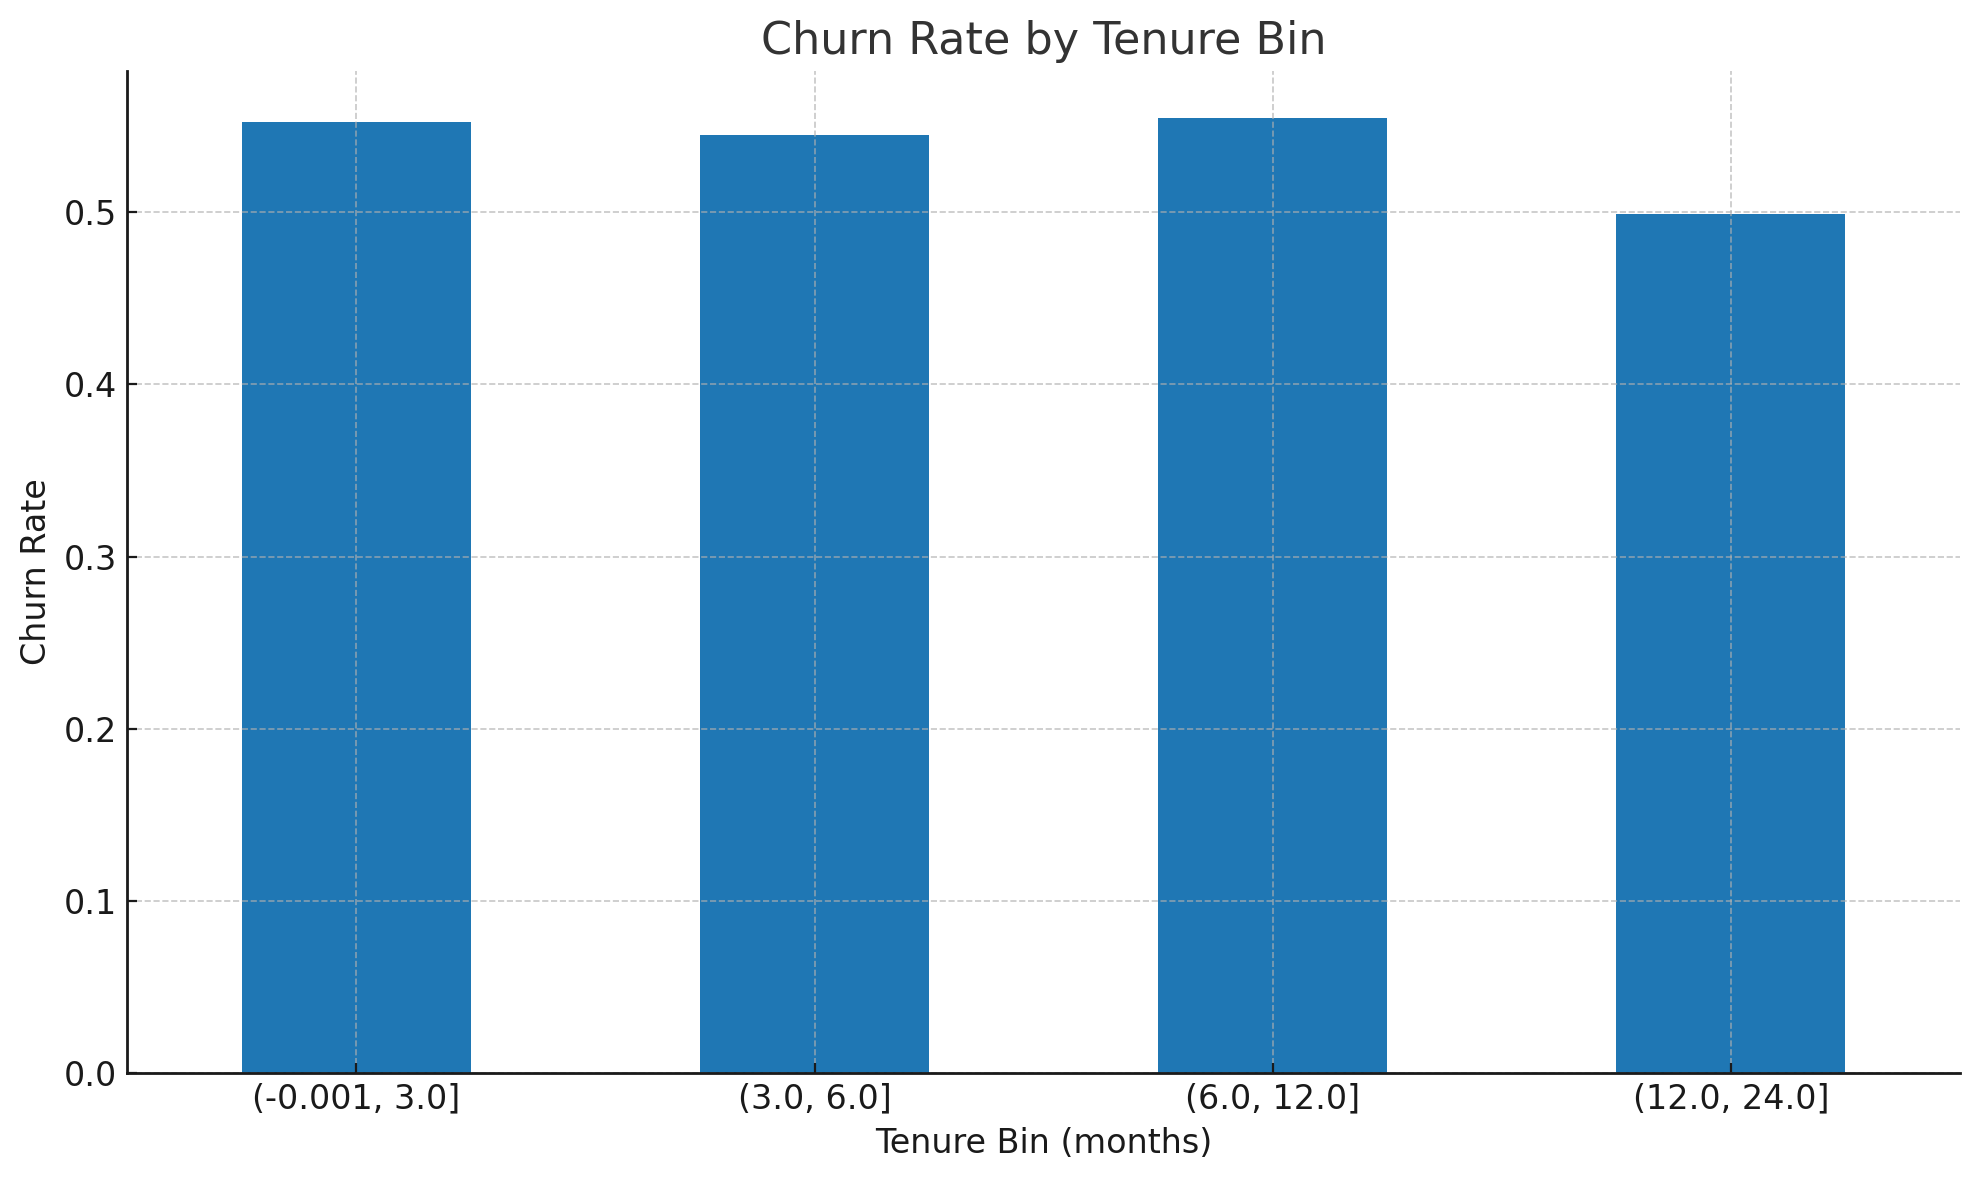

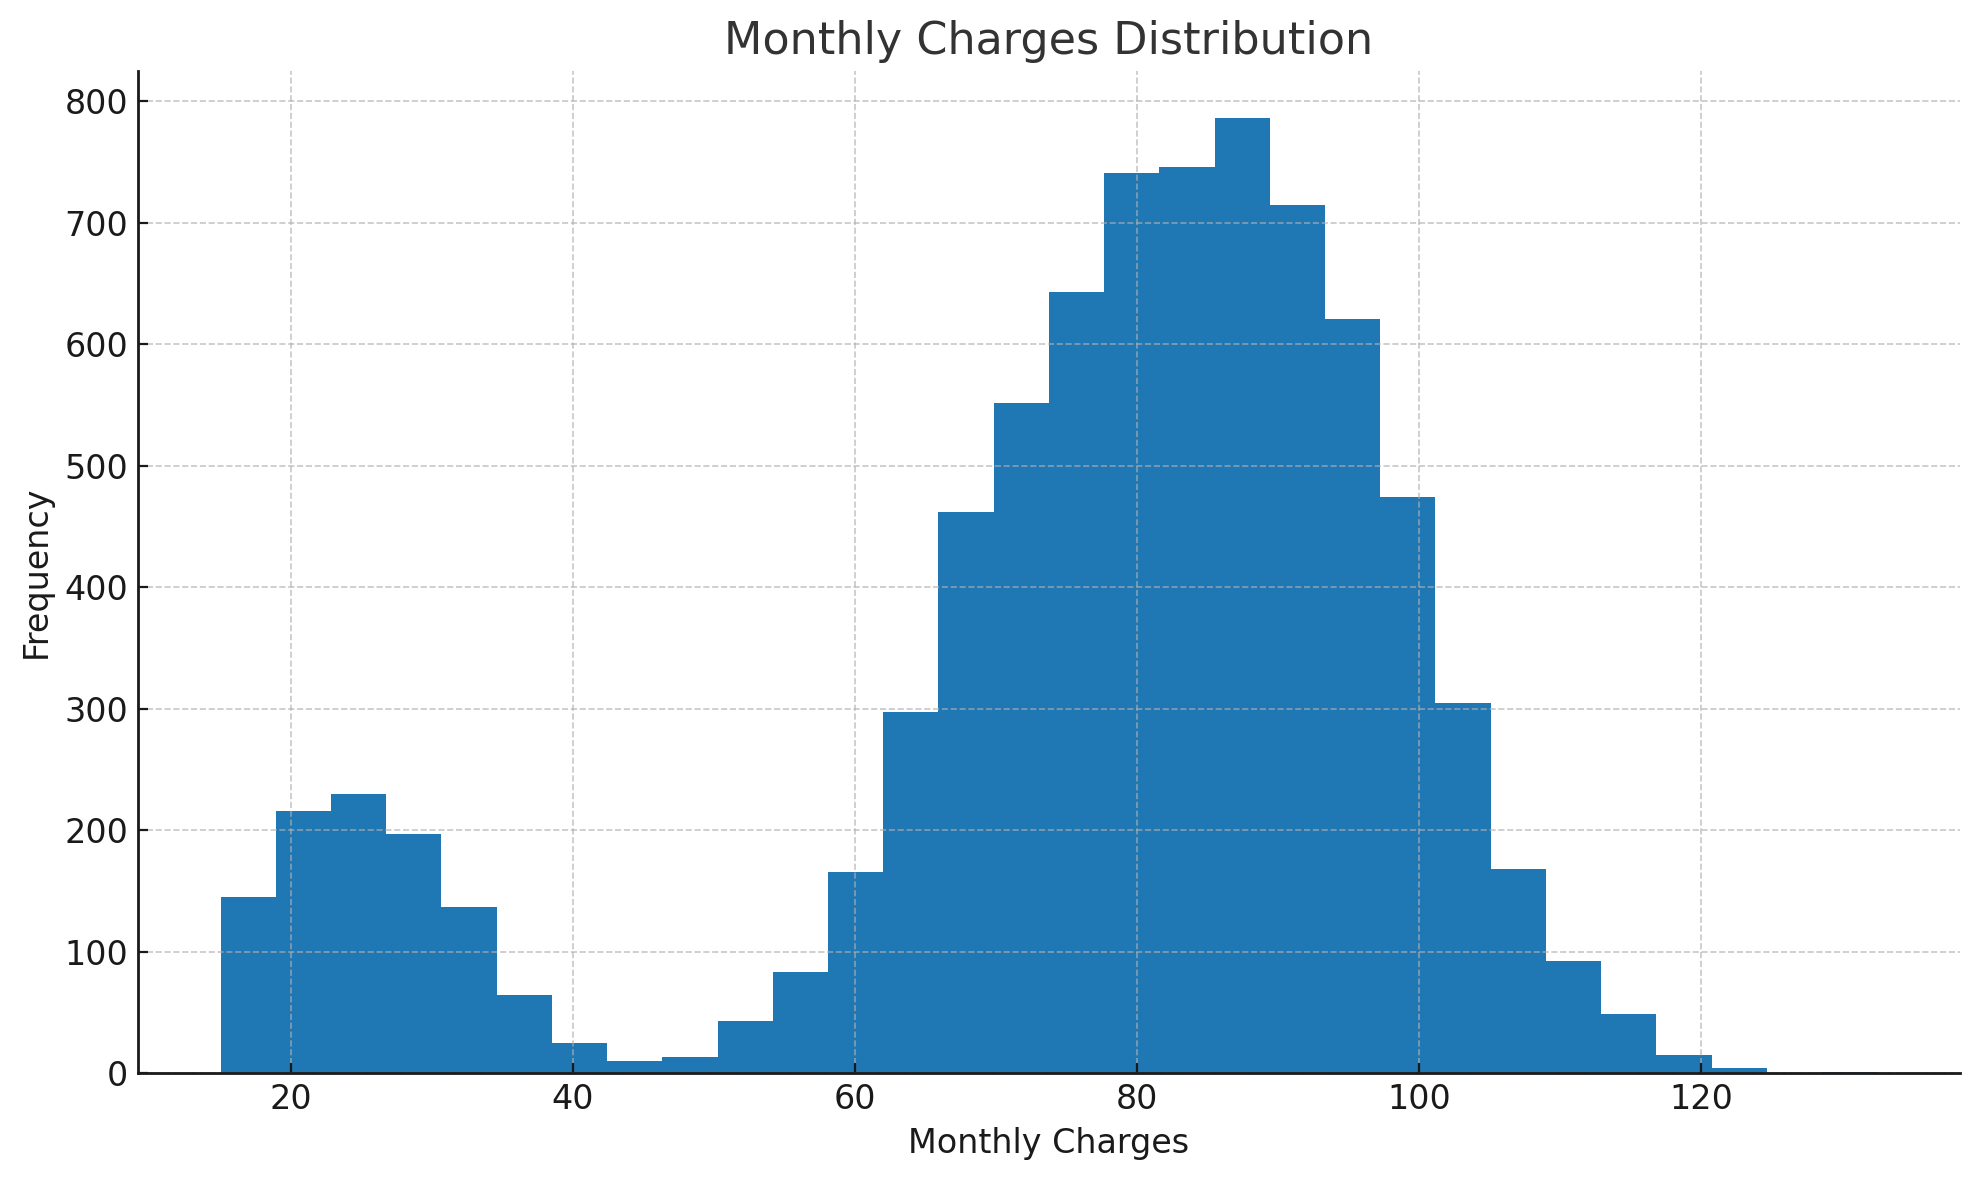

In [2]:
# --- Quick EDA ---
print("Shape:", df.shape)
print("\nChurn rate:", df['churn'].mean().round(3))

print("\nContract distribution:")
print(df['contract'].value_counts(normalize=True).round(3))

print("\nPayment method distribution:")
print(df['payment_method'].value_counts(normalize=True).round(3))

print("\nInternet service distribution:")
print(df['internet_service'].value_counts(normalize=True).round(3))

# Plot churn by contract
churn_by_contract = df.groupby('contract')['churn'].mean().sort_values(ascending=False)
plt.figure()
churn_by_contract.plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Contract')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Tenure vs churn (box-like by bins)
df['tenure_bin'] = pd.cut(df['tenure_months'], bins=[0,3,6,12,24], include_lowest=True)
churn_by_tenure = df.groupby('tenure_bin')['churn'].mean()
plt.figure()
churn_by_tenure.plot(kind='bar')
plt.title('Churn Rate by Tenure Bin')
plt.ylabel('Churn Rate')
plt.xlabel('Tenure Bin (months)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Charges distribution
plt.figure()
df['monthly_charges'].plot(kind='hist', bins=30)
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges')
plt.tight_layout()
plt.show()


In [3]:
# --- Preprocessing & Split ---
X = df.drop(columns=['churn', 'tenure_bin'])
y = df['churn']

numeric_features = ['age', 'tenure_months', 'monthly_charges', 'total_charges']
categorical_features = ['contract', 'payment_method', 'internet_service']
binary_features = ['online_security', 'online_backup', 'device_protection', 'tech_support',
                   'streaming_tv', 'streaming_movies', 'paperless_billing', 'senior_citizen']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Logistic Regression
              precision    recall  f1-score   support

           0      0.606     0.500     0.548       760
           1      0.609     0.706     0.654       840

    accuracy                          0.608      1600
   macro avg      0.608     0.603     0.601      1600
weighted avg      0.608     0.608     0.604      1600

ROC AUC: 0.628


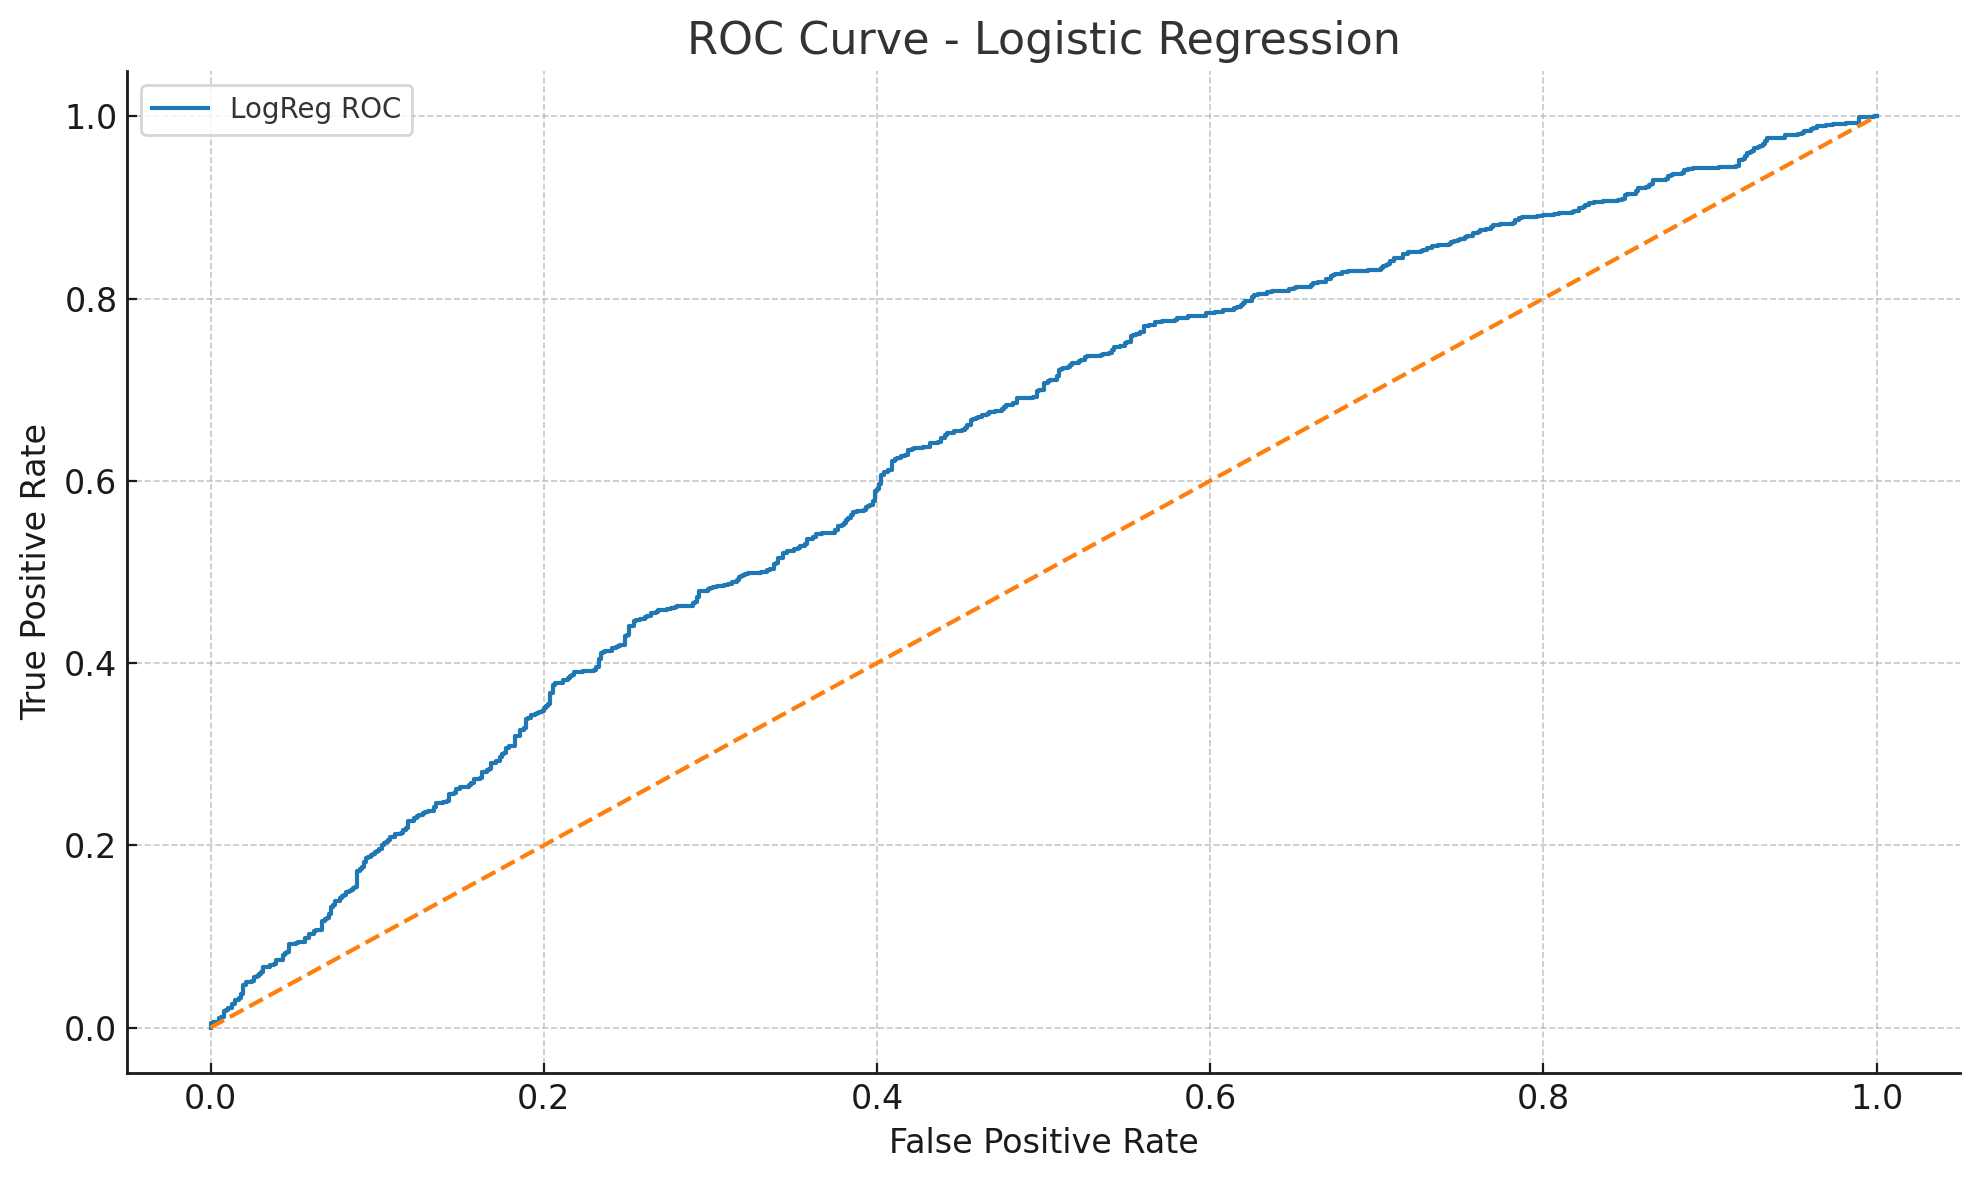

In [4]:
# --- Logistic Regression ---
log_reg = Pipeline(steps=[('preprocess', preprocess),
                         ('model', LogisticRegression(max_iter=200, n_jobs=None, solver='lbfgs'))])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr).round(3))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
plt.figure()
plt.plot(fpr, tpr, label='LogReg ROC')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


Random Forest
              precision    recall  f1-score   support

           0      0.564     0.499     0.529       760
           1      0.589     0.651     0.619       840

    accuracy                          0.579      1600
   macro avg      0.577     0.575     0.574      1600
weighted avg      0.577     0.579     0.576      1600

ROC AUC: 0.594


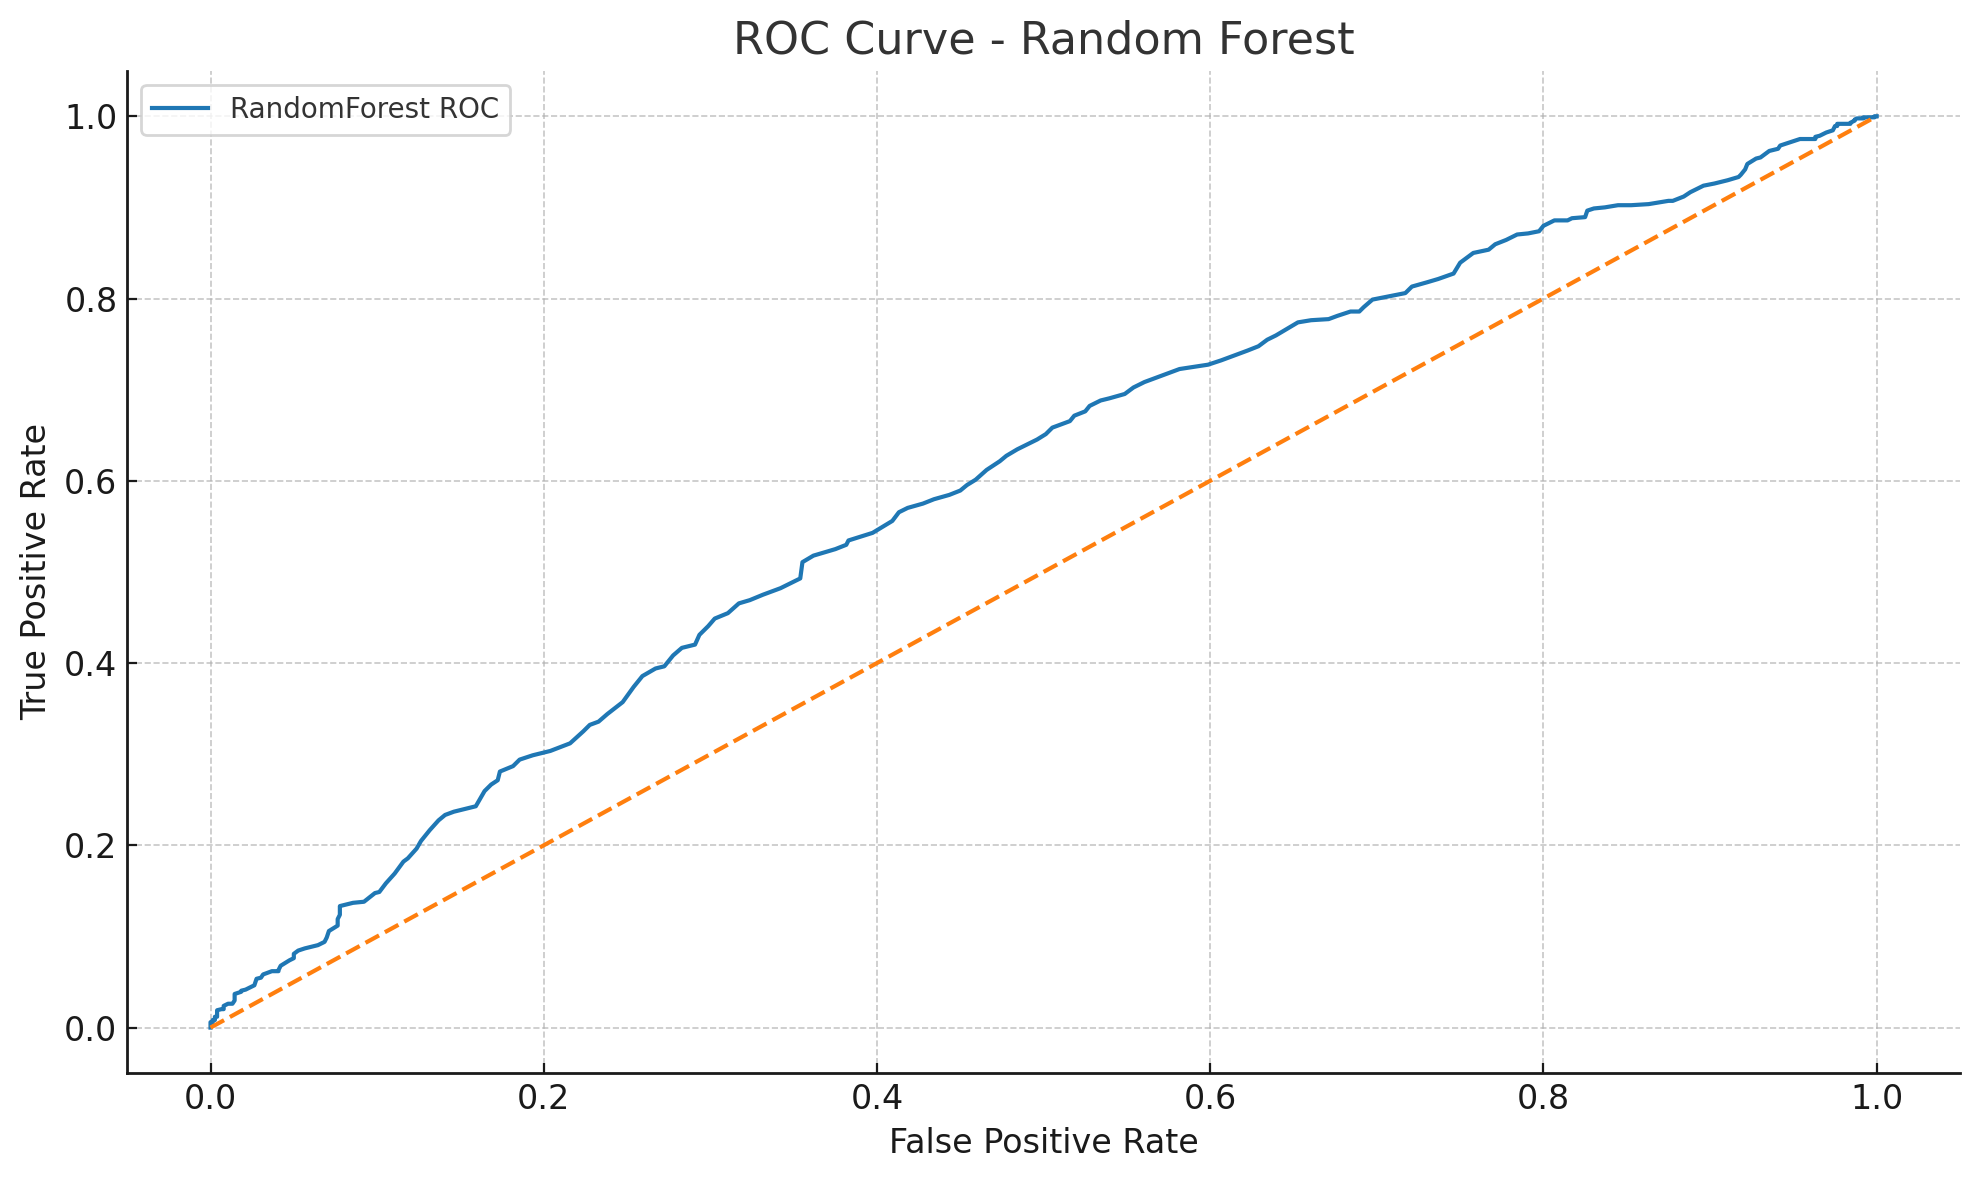

In [5]:
# --- Random Forest ---
rf = Pipeline(steps=[('preprocess', preprocess),
                    ('model', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf).round(3))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr, tpr, label='RandomForest ROC')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


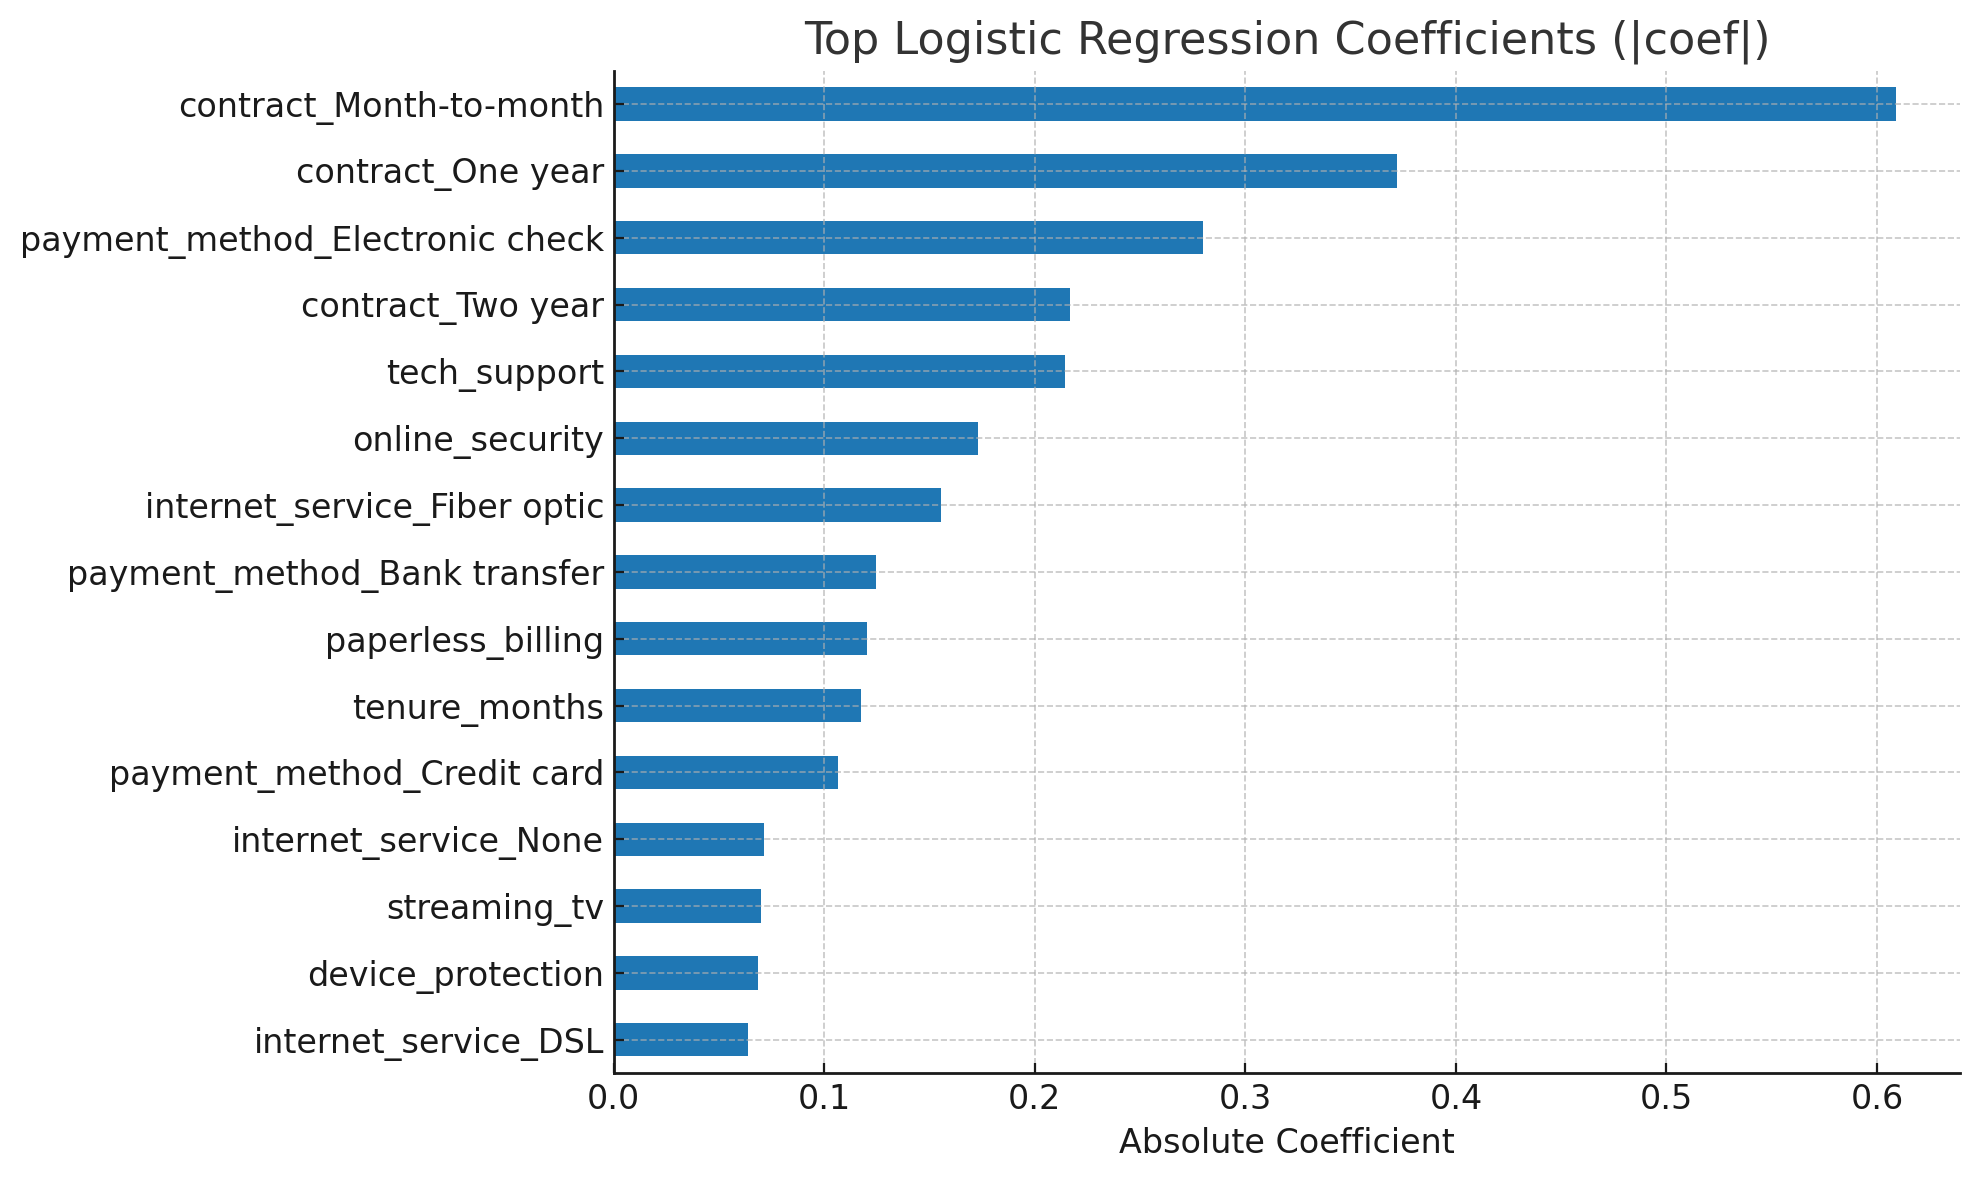

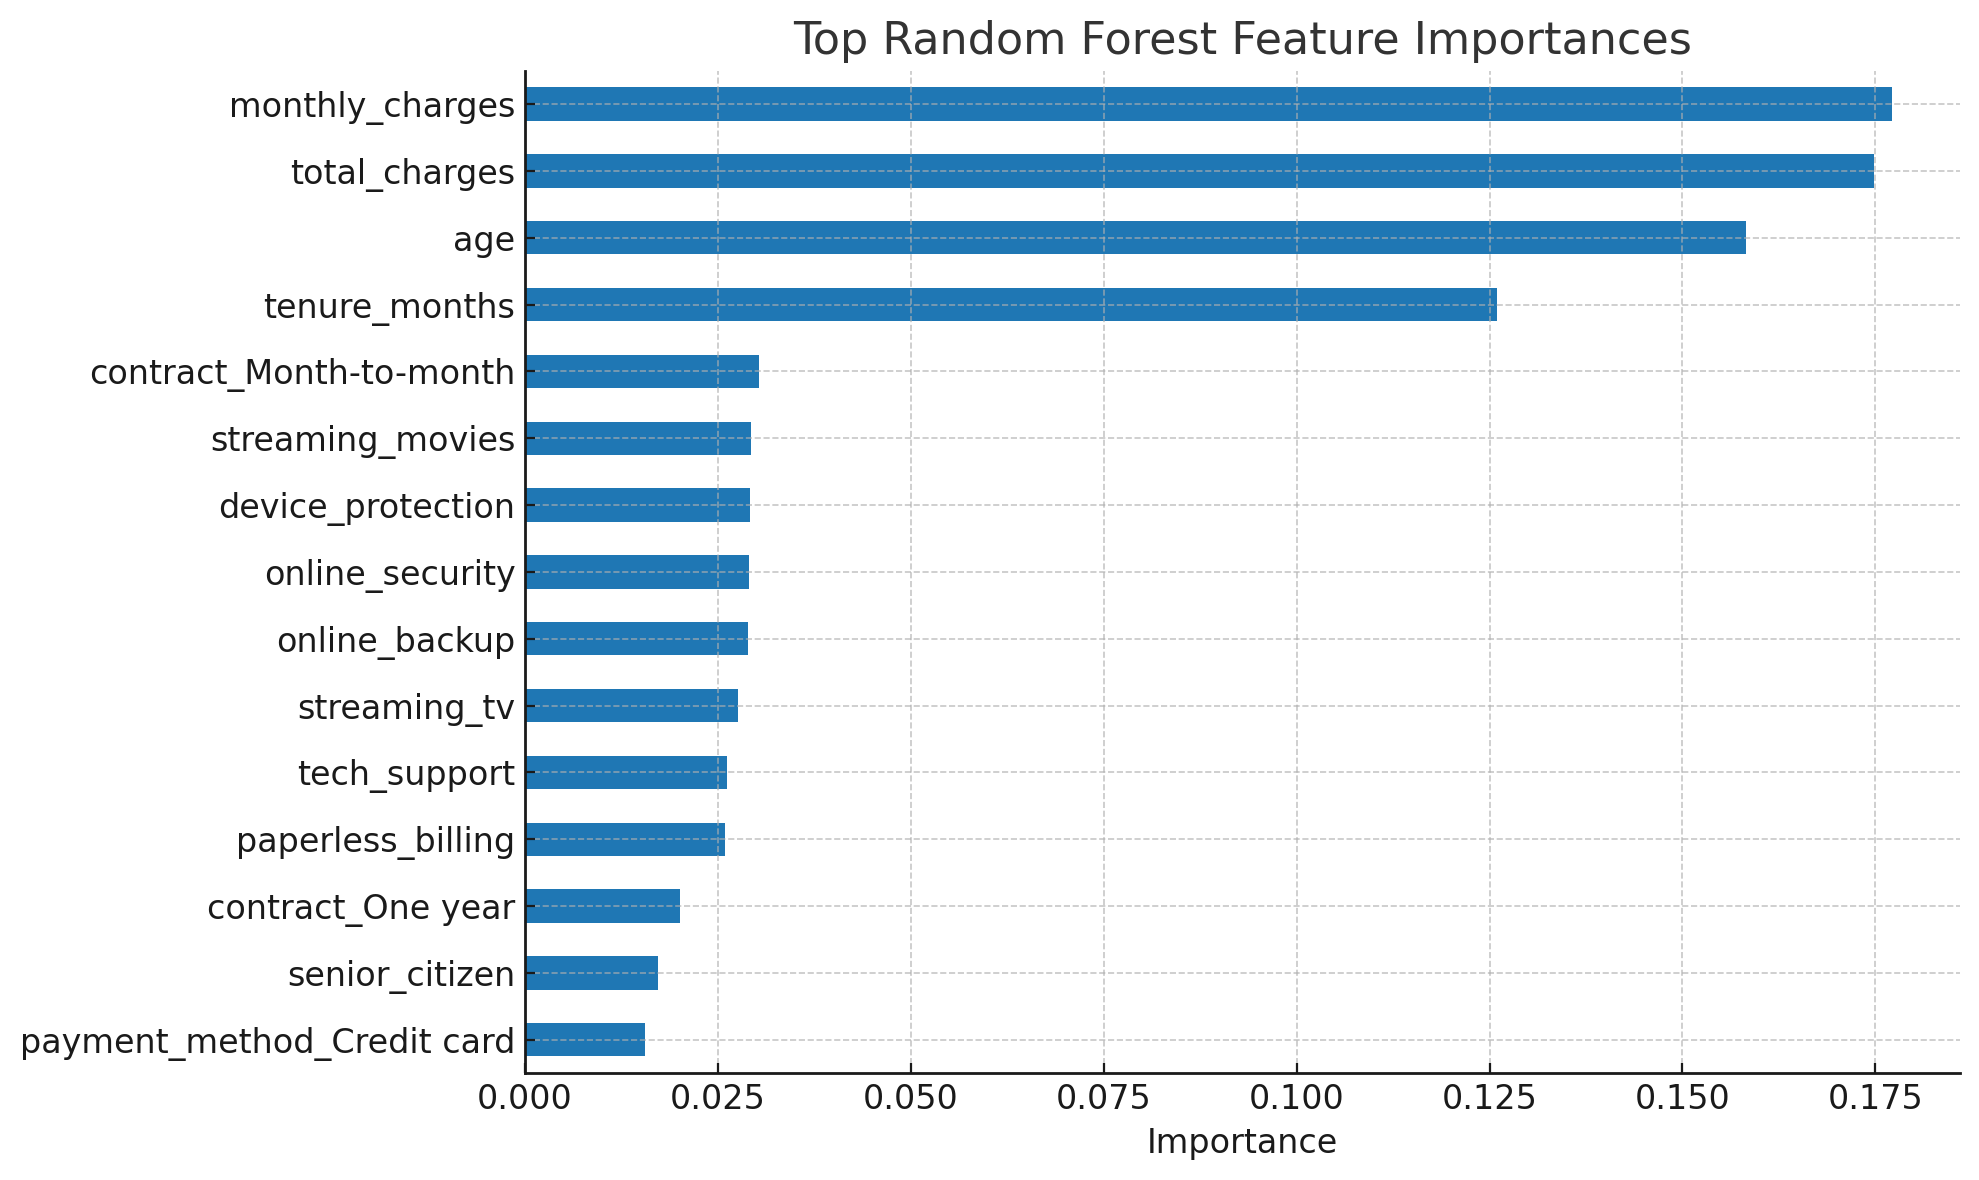

In [6]:
# --- Interpretability ---
# Pull feature names after preprocessing to map importances
ohe = log_reg.named_steps['preprocess'].transformers_[1][1]  # OneHotEncoder
ohe_features = ohe.get_feature_names_out(['contract','payment_method','internet_service'])

feature_names = (numeric_features + list(ohe_features) + binary_features)

# Logistic Regression coefficients (absolute values for ranking)
lr_coef = log_reg.named_steps['model'].coef_[0]
lr_importance = pd.Series(np.abs(lr_coef), index=feature_names).sort_values(ascending=False).head(15)

plt.figure()
lr_importance.sort_values().plot(kind='barh')
plt.title('Top Logistic Regression Coefficients (|coef|)')
plt.xlabel('Absolute Coefficient')
plt.tight_layout()
plt.show()

# Random Forest feature importances
# Need to retrieve from the fitted model; ColumnTransformer outputs arrays in the same order
rf_importances = rf.named_steps['model'].feature_importances_
rf_importance = pd.Series(rf_importances, index=feature_names).sort_values(ascending=False).head(15)

plt.figure()
rf_importance.sort_values().plot(kind='barh')
plt.title('Top Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [7]:
# --- Business Insights (auto-generated) ---
churn_rate = y_test.mean()
print(f"Holdout churn rate: {churn_rate:.3f}")

print("\nTop levers to watch:")
print("• Month-to-month contracts and electronic check payments correlate with higher churn.")
print("• Short tenure customers churn more; early-life interventions can help.")
print("• Lack of tech support/online security associates with churn; bundle support services.")
print("• Higher monthly charges push churn; consider loyalty discounts or tiered pricing.")


Holdout churn rate: 0.525

Top levers to watch:
• Month-to-month contracts and electronic check payments correlate with higher churn.
• Short tenure customers churn more; early-life interventions can help.
• Lack of tech support/online security associates with churn; bundle support services.
• Higher monthly charges push churn; consider loyalty discounts or tiered pricing.
